True

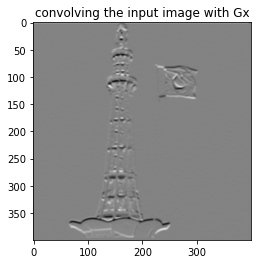

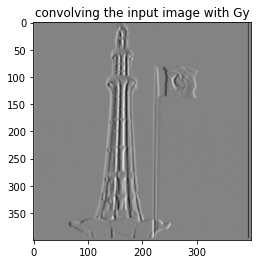

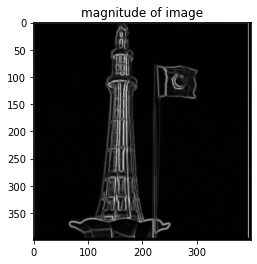

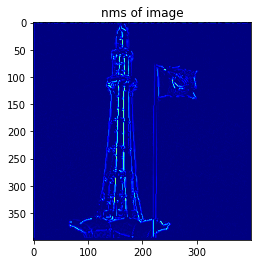

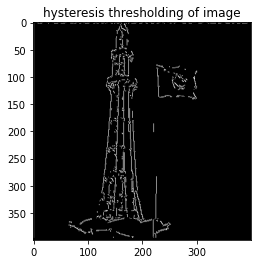

In [207]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import math 
import os.path


# changable values

img_name = '2.jpg'
th = 50
tl = 20

sigma = 1
T = 0.3



# 1. Generation of Masks

filename, file_extension = os.path.splitext(img_name)
img = read_image('Dataset/'+img_name)

half_mask_size = 0.0

    
def take_input():
    global sigma 
    global T
    sigma = float(input("Enter Sigma:")) 
    
    while sigma < 0.5 :
        sigma = float(input("Enter Sigma above or equal to 0.5 :")) 
    
    T = float(input("Enter T:")) 

    while not(T <= 1 and T > 0):
        T = float(input("Enter T between 0 and 1 :")) 
        
        
def calculate_filter_size (sigma, T): 
    global half_mask_size
    half_mask_size  = np.round(math.sqrt(-np.log(T) * 2 * (sigma**2)))
    mask_size = (2*half_mask_size) +1
    return mask_size
        
    
def create_filter(filter_size, sigma):
    global half_mask_size
    Y, X = np.meshgrid(range(-int(half_mask_size) , int(half_mask_size)+1),  range(-int(half_mask_size), int(half_mask_size)+1) )
     
    gaussian = np.exp(-((X**2 + Y**2)/(2*(sigma**2))))
    temp  = (1/(2*np.pi*(sigma)))*Gaussian
    

    gx =(X * gaussian) /(sigma**2)
    gx = np.around(gx*255)
    
    gy = (Y* gaussian)/(sigma**2)
    gy = np.round(gy*255)
    
#     for visualization of matrix
#     fig = plt.figure()
#     ax = fig.add_subplot(1,1,1,projection='3d')
#     ax.plot_surface(X, Y, gx, cmap='summer')
    
    return gx, gy, gaussian


take_input() 

filter_size  = calculate_filter_size (sigma, T) 
gx, gy, gaussian = create_filter(filter_size, sigma)


# -----------------------------------------------------------------------------------
# 2. Applying Masks to Images, Compute gradient magnitude, Compute gradient Direction

# read the image
 
def read_image(image_name):
    img = cv2.imread(image_name,  cv2.IMREAD_GRAYSCALE)   
    return img

def padding(img, filter):
     
    img_height, img_width = img.shape
    filter_height, filter_width = filter.shape
    mid_height = round(filter_height/2)
    mid_width = round(filter_width/2)
    
    padded_img = np.zeros((img_height + filter_height , img_width + filter_width), dtype=img.dtype)
    padded_img[mid_height: mid_height + img_height, mid_width: mid_width + img_width] = img
    
    return padded_img


def smoothing(img, filter):
    
    padded_img = padding(img, filter)
    
    
    img_height, img_width = img.shape
    fx = np.zeros((img_height, img_width))
    filter_height, filter_width = filter.shape 
    
    for i in range(img_height):
        for j in range(img_width-(filter_width-1)):  
             fx[i, j] = (filter * padded_img[i:i+filter_height, j:j+filter_width]).sum() / filter.sum()  
             
    return fx
                    
 
def convol_mask(smooth_img, filter):
    
    padded_img = padding(smooth_img, filter)
    
    img_height, img_width = smooth_img.shape
    filter_height, filter_width = filter.shape 
    
    mid_height = (round(filter_height/2))-1
    mid_width = (round(filter_width/2))-1
    
    fx = smooth_img.copy()
    
    for i in range(img_height-(filter_height-1)):
        for j in range(img_width-(filter_width-1)):  
            for k in range(filter_height):
                for l in range(filter_width):
                    fx[i,j] += (padded_img[i + k, j + l]*filter[k, l]) 
    return fx


smooth_img = smoothing(img, gaussian) 

fx = convol_mask(smooth_img, gx)
fy = convol_mask(smooth_img, gy)

plt.figure()
plt.title('convolving the input image with Gx') 
plt.imshow(fx, cmap='gray')
# cv2.imwrite('Result/fx_'+filename+'.jpg', fx)

plt.figure()
plt.title('convolving the input image with Gy') 
plt.imshow(fy, cmap='gray')
# cv2.imwrite('Result/fy_'+filename+'.jpg', fy)

def magnitude(fx, fy):
    m = np.sqrt(np.square(fx) + np.square(fy))
    temp = np.divide(m, np.max(m))

    m = np.multiply(temp, 255)
    return m

m = magnitude(fx, fy)

plt.figure()
plt.title('magnitude of image') 
plt.imshow(m, cmap='gray')
# cv2.imwrite('Result/magnitude_'+filename+'.jpg', m)

# Compute gradient Direction
img_height, img_width = img.shape
gradient_direction = np.zeros((img_height, img_width), dtype=img.dtype)
DEGREE = 180/math.pi

for i in range(img_height):
    for j in range(img_width):
        gradient_direction[i,j] = (math.atan2(fy[i,j], fx[i,j]) * DEGREE)+180
            

# plt.figure()  
# plt.title('gradient direction of image') 
# plt.imshow(gradient_direction, cmap='gray')

# -----------------------------------------------------------------------------------
# 3. Non-Maxima Suppression

# quantize gradient direction into just four directions

for i in range(img_height):
    for j in range(img_width):
        if (gradient_direction[i,j] >= 0 and gradient_direction[i,j] <= 22.5) or (gradient_direction[i,j] >= 157.5 and gradient_direction[i,j] <= 202.5) or (gradient_direction[i,j] >= 337.5 and gradient_direction[i,j] <= 360):
            gradient_direction[i,j]  = 0
        elif (gradient_direction[i,j] > 22.5 and gradient_direction[i,j] <= 67.5) or (gradient_direction[i,j] > 202.5 and gradient_direction[i,j] <= 247.5):
            gradient_direction[i,j]  = 1
        elif (gradient_direction[i,j] > 67.5 and gradient_direction[i,j] <= 112.5) or (gradient_direction[i,j] > 247.5 and gradient_direction[i,j] <= 292.5):
            gradient_direction[i,j]  = 2
        elif (gradient_direction[i,j] > 112.5 and gradient_direction[i,j] < 157.5) or (gradient_direction[i,j] > 292.5 and gradient_direction[i,j] < 337.5):
            gradient_direction[i,j]  = 3

def greater_neighbors(current, neighbor_1, neighbor_2):
    if (current > neighbor_1 and current > neighbor_2):
        return current
    else:
        return 0
                    

for i in range(img_height): 
    for j in range(img_width):
        if(gradient_direction[i,j] ==  0):
            if (j-1 >= 0 and j+1 < img_width):
                m[i, j] = greater_neighbors(m[i, j], m[i, j-1], m[i, j+1])      
            else:
                m[i, j] = 0
        elif(gradient_direction[i,j] ==  1 or gradient_direction[i,j] ==  3):
            if (i-1 > 0 and j-1 > 0 and j+1 < img_width and i+1 < img_height):
                if gradient_direction[i,j] ==  1 :
                    m[i, j] = greater_neighbors(m[i, j], m[i-1, j+1], m[i+1, j-1])
                elif gradient_direction[i,j] ==  3 :
                    m[i, j] = greater_neighbors(m[i, j], m[i+1, j-1], m[i-1, j+1]) 
            else:
                m[i, j] = 0
        elif(gradient_direction[i,j] ==  2):
            if not(i-1 > 0 and i+1 < img_height):
                m[i, j] = greater_neighbors(m[i, j], m[i-1, j], m[i+1, j])      
            else:
                m[i, j] = 0

plt.figure()
plt.title('nms of image') 
plt.imshow(m, cmap='jet')
# cv2.imwrite('Result/quantized_'+filename+'.jpg', m)       
# -----------------------------------------------------------------------------------                
# 4. Hysteresis Thresholding

# border pixels zero

j = 0
for i in range(img_height): 
    m[i,j] ==  0
    m[i,img_width-1] ==  0
    
j = 0
for i in range(img_width): 
    m[j,i] ==  0
    m[img_height-1, i] ==  0




def thresholding(m, th, tl):
    img_height, img_width = m.shape
    thresholded_img = np.zeros((img_height, img_width))
    
    for i in range(img_height):
        for j in range(img_width):
            if m[i,j] > tl and m[i,j] < th:
                thresholded_img[i,j] = 128
            elif m[i,j] <= tl:
                thresholded_img[i,j] = 0 
            else:
                thresholded_img[i,j] = 255
                
    return thresholded_img

thresholded_img = thresholding(m, th, tl)

# plt.figure()  
# plt.title('after thresholding of image') 
# plt.imshow(thresholded_img, cmap='gray')

def hysteresis_thresholding(thresholded_img):
    
    img_height, img_width = thresholded_img.shape
    strong_m = thresholded_img.copy()
                                
    for i in range(img_height):
        for j in range(img_width):
            if thresholded_img[i,j] == 128:
                if thresholded_img[i-1,j] == 255 or thresholded_img[i-1,j+1] == 255 or thresholded_img[i-1,j-1] == 255 or thresholded_img[i+1,j-1] == 255  or thresholded_img[i+1,j+1] == 255 or thresholded_img[i,j-1] == 255 or thresholded_img[i,j+1] == 255 or thresholded_img[i+1,j] == 255:
                    strong_m[i,j] = 255
                else:
                   strong_m[i,j] = 0 
                
    return strong_m

result = hysteresis_thresholding(thresholded_img) 

plt.figure()  
plt.title('hysteresis thresholding of image') 
plt.imshow(result, cmap='gray')
# cv2.imwrite('Result/hysteresis_thresholding_'+filename+'.jpg', result) 
cv2.imwrite('Result/th_'+str(th)+'_tl_'+str(tl)+'_s_1_'+filename+'.jpg', result) 

